In [1]:
pip install pandas numpy matplotlib seaborn scipy networkx tensorflow scikit-learn torch torch-geometric geopandas folium geopy opencage requests pip certifi pyproj geopandas libpysal

In [12]:
import numpy as np
import pandas as pnd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import json
import requests
import pyproj  # Import the pyproj module
from pyproj import CRS, Transformer
import geopandas as gpd
import os
import sys

In [14]:
# Read the Excel file
file_path = 'scrum_metrics.xlsx'  # Specify the path to your Excel file
df = pnd.read_excel(file_path)

# Preview the first few rows of the Excel data
print("Data from Excel file:\n", df.head(30))

Data from Excel file:
    Team                        Metric  Sprint 1   Sprint 2  Sprint 3  \
0     A                   Working env       1.0   0.850000      0.75   
1     A                      Maturity       0.5   0.250000      1.00   
2     A                Complexity avg       0.5   0.250000      1.00   
3     A           Sprint Goal Success       1.0   0.750000      0.80   
4     A             Cycle Time (days)       5.0   6.000000      6.00   
5     A              Lead Time (days)      10.0   8.000000     12.00   
6     A                         Ratio       0.5   0.750000      0.50   
7     A            Team Success score       0.5   0.478125      0.30   
8     B  Sprint Goal Success Rate (%)      70.0  75.000000     80.00   
9     B             Cycle Time (days)       6.0   7.000000      5.00   
10    B              Lead Time (days)      11.0  10.000000      9.00   
11    C          Sprint Goal Success       90.0  88.000000     85.00   
12    C             Cycle Time (days)    

In [15]:
# Define a function to calculate Recency Weighting for a given metric
def calculate_recency_weighting(row):
    recency_weighting_score = 0
    total_weight = 0
    for i in range(1, 5):  # Loop through Sprint 1 to Sprint 4 (update if there are more sprints)
        sprint_value = row[f'Sprint {i}']  # Get the sprint value for the metric
        
        print(f"Sprint {i}:")
        print(f"  Sprint Value: {sprint_value}")
        weight = i  # Sprint number is the weight
        print(f"  Weight: {weight}")
        
        recency_weighting_score += sprint_value * weight
        print(f"  Total Weighted Score (so far): {recency_weighting_score}")
        
        total_weight += weight
        print(f"  Total Weight (so far): {total_weight}")
        
    recency_weighted_average = recency_weighting_score / total_weight if total_weight > 0 else 0  # Weighted average
    return recency_weighted_average, recency_weighting_score  # Return both average and total score

# Apply the function to each row to calculate the Recency Weighted score
recency_weighting_results = df.apply(calculate_recency_weighting, axis=1)

# Split the results into two separate columns
df['Recency Weighting Average'], df['Recency Weighting Score'] = zip(*recency_weighting_results)

# Output the DataFrame with Recency Weighting for each metric
print(df[['Metric', 'Recency Weighting Average', 'Recency Weighting Score']])

# Save the updated DataFrame to a new CSV file
df.to_csv('metrics_with_recency_weighting.csv', index=False)


Sprint 1:
  Sprint Value: 1.0
  Weight: 1
  Total Weighted Score (so far): 1.0
  Total Weight (so far): 1
Sprint 2:
  Sprint Value: 0.85
  Weight: 2
  Total Weighted Score (so far): 2.7
  Total Weight (so far): 3
Sprint 3:
  Sprint Value: 0.75
  Weight: 3
  Total Weighted Score (so far): 4.95
  Total Weight (so far): 6
Sprint 4:
  Sprint Value: 0.65
  Weight: 4
  Total Weighted Score (so far): 7.550000000000001
  Total Weight (so far): 10
Sprint 1:
  Sprint Value: 0.5
  Weight: 1
  Total Weighted Score (so far): 0.5
  Total Weight (so far): 1
Sprint 2:
  Sprint Value: 0.25
  Weight: 2
  Total Weighted Score (so far): 1.0
  Total Weight (so far): 3
Sprint 3:
  Sprint Value: 1.0
  Weight: 3
  Total Weighted Score (so far): 4.0
  Total Weight (so far): 6
Sprint 4:
  Sprint Value: 0.75
  Weight: 4
  Total Weighted Score (so far): 7.0
  Total Weight (so far): 10
Sprint 1:
  Sprint Value: 0.5
  Weight: 1
  Total Weighted Score (so far): 0.5
  Total Weight (so far): 1
Sprint 2:
  Sprint Value

   Team  Recency Weighting Average  Recency Weighting Score
0     A                       82.0                      820
1     A                        5.1                       51
2     A                        9.8                       98
3     B                       80.0                      800
4     B                        5.9                       59
..  ...                        ...                      ...
73    Y                        4.4                       44
74    Y                        7.4                       74
75    Z                       92.2                      922
76    Z                        3.4                       34
77    Z                        6.4                       64

[78 rows x 3 columns]


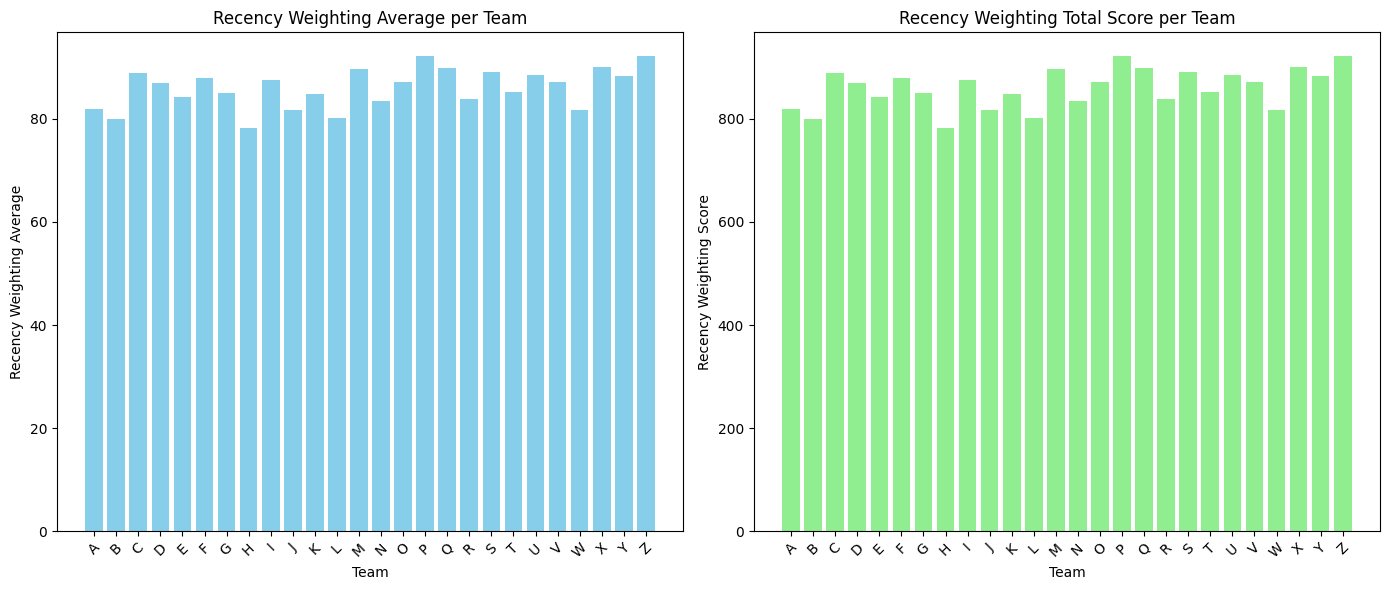

In [4]:
# Read the CSV file (assuming it was saved from previous steps)
df = pnd.read_csv('metrics_with_recency_weighting.csv')

# Preview the updated DataFrame with Recency Weighting
print(df[['Team', 'Recency Weighting Average', 'Recency Weighting Score']])

# Plotting the Recency Weighting Average and Score for each team
teams = df['Team']  

# Create subplots to show Recency Weighting Average and Recency Weighting Score
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Recency Weighting Average
ax[0].bar(teams, df['Recency Weighting Average'], color='skyblue')
ax[0].set_title('Recency Weighting Average per Team')
ax[0].set_xlabel('Team')
ax[0].set_ylabel('Recency Weighting Average')
ax[0].tick_params(axis='x', rotation=45)

# Plot Recency Weighting Score
ax[1].bar(teams, df['Recency Weighting Score'], color='lightgreen')
ax[1].set_title('Recency Weighting Total Score per Team')
ax[1].set_xlabel('Team')
ax[1].set_ylabel('Recency Weighting Score')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()


In [5]:
# Define a function to assign the Metric Weighting value based on the Metric type
def assign_metric_weighting(row):
    if row['Metric'] == 'Sprint Goal Success Rate (%)':
        return 3
    elif row['Metric'] == 'Cycle Time (days)':
        return 2
    elif row['Metric'] == 'Lead Time (days)':
        return 1
    else:
        return 0  # Default if metric doesn't match

# Apply the function to create the new 'Metric Weighting' column
df['Metric Weighting'] = df.apply(assign_metric_weighting, axis=1)

# Preview the DataFrame to check the new column
print(df[['Metric', 'Metric Weighting']])

                          Metric  Metric Weighting
0   Sprint Goal Success Rate (%)                 3
1              Cycle Time (days)                 2
2               Lead Time (days)                 1
3   Sprint Goal Success Rate (%)                 3
4              Cycle Time (days)                 2
..                           ...               ...
73             Cycle Time (days)                 2
74              Lead Time (days)                 1
75  Sprint Goal Success Rate (%)                 3
76             Cycle Time (days)                 2
77              Lead Time (days)                 1

[78 rows x 2 columns]


In [6]:
# Create a new column 'Weighted Score' by multiplying 'Recency Weighting Score' with 'Metric Weighting'
df['Weighted Score'] = df['Recency Weighting Score'] * df['Metric Weighting']

# Preview the DataFrame to check the new column
print(df[['Metric', 'Recency Weighting Score', 'Metric Weighting', 'Weighted Score']])

# Save the updated DataFrame to a CSV file
df.to_csv('metrics_with_weighted_score.csv', index=False)

                          Metric  Recency Weighting Score  Metric Weighting  \
0   Sprint Goal Success Rate (%)                      820                 3   
1              Cycle Time (days)                       51                 2   
2               Lead Time (days)                       98                 1   
3   Sprint Goal Success Rate (%)                      800                 3   
4              Cycle Time (days)                       59                 2   
..                           ...                      ...               ...   
73             Cycle Time (days)                       44                 2   
74              Lead Time (days)                       74                 1   
75  Sprint Goal Success Rate (%)                      922                 3   
76             Cycle Time (days)                       34                 2   
77              Lead Time (days)                       64                 1   

    Weighted Score  
0             2460  
1        

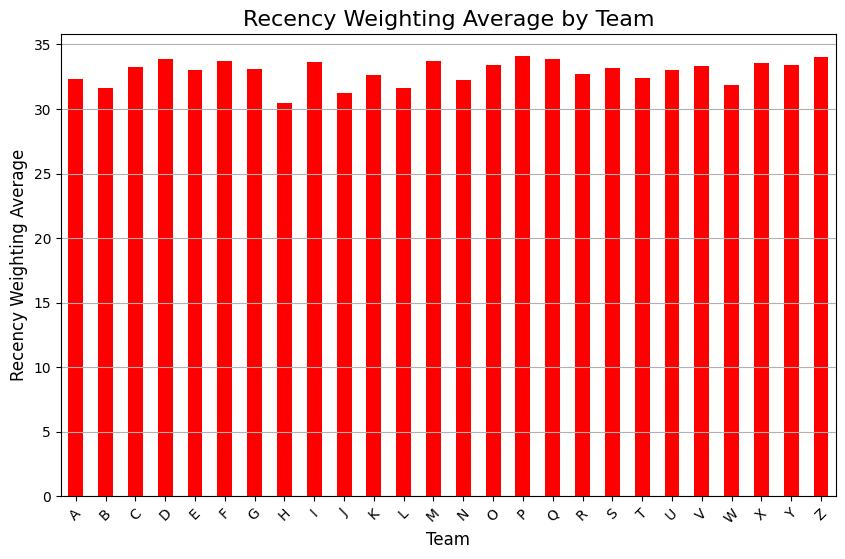

In [7]:
# Group by 'Team' and calculate the average of 'Recency Weighting Average' across all sprints
team_avg_recency = df.groupby('Team')['Recency Weighting Average'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each team's average recency weighting
team_avg_recency.plot(kind='bar', color='red')

# Adding titles and labels
plt.title('Recency Weighting Average by Team', fontsize=16)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Recency Weighting Average', fontsize=12)

# Rotate the team names on x-axis for better readability
plt.xticks(rotation=45)

plt.grid(axis='y')

plt.show()

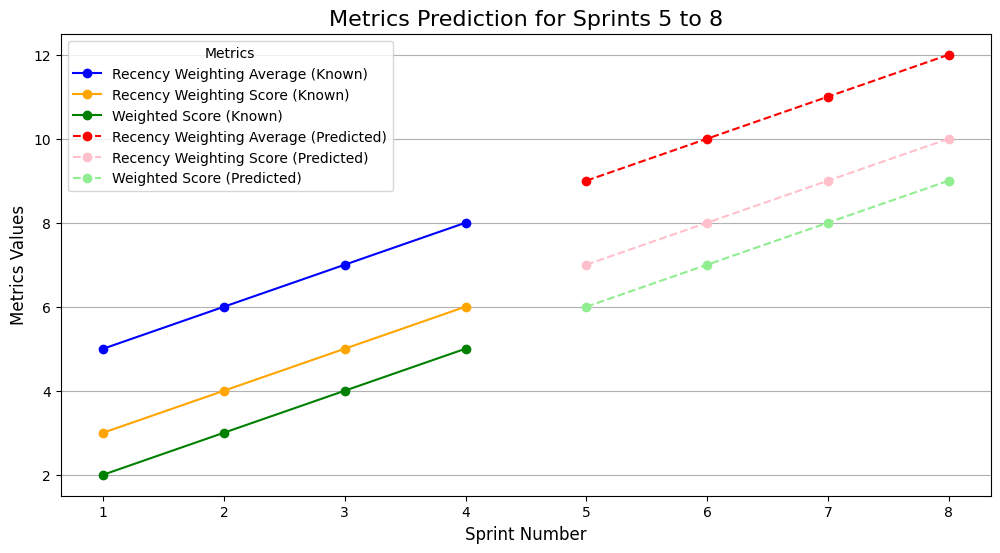

In [10]:
from sklearn.linear_model import LinearRegression


# Prepare the data (adjust according to your DataFrame)
sprints = np.array([1, 2, 3, 4])
metrics = ['Recency Weighting Average', 'Recency Weighting Score', 'Weighted Score']

# Initialize a dictionary to store predictions
predictions = {metric: [] for metric in metrics}

# Create a linear regression model for each metric
for metric in metrics:
    # Extract the known values for the metric
    known_values = df[metric].iloc[:4].values.reshape(-1, 1)  # Values for Sprints 1-4
    model = LinearRegression()
    model.fit(sprints.reshape(-1, 1), known_values)  # Fit the model
    
    # Predict for Sprints 5 to 8
    sprint_to_predict = np.array([5, 6, 7, 8]).reshape(-1, 1)
    predicted_values = model.predict(sprint_to_predict)
    
    # Store predictions
    predictions[metric] = predicted_values.flatten()

# Prepare for plotting
sprint_labels = np.concatenate([sprints, sprint_to_predict.flatten()])
recency_weighting_avg = np.concatenate([df['Recency Weighting Average'].iloc[:4].values, predictions['Recency Weighting Average']])
recency_weighting_score = np.concatenate([df['Recency Weighting Score'].iloc[:4].values, predictions['Recency Weighting Score']])
weighted_score = np.concatenate([df['Weighted Score'].iloc[:4].values, predictions['Weighted Score']])

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot known data (Sprints 1-4)
plt.plot(sprints, df['Recency Weighting Average'].iloc[:4], marker='o', label='Recency Weighting Average (Known)', color='blue')
plt.plot(sprints, df['Recency Weighting Score'].iloc[:4], marker='o', label='Recency Weighting Score (Known)', color='orange')
plt.plot(sprints, df['Weighted Score'].iloc[:4], marker='o', label='Weighted Score (Known)', color='green')

# Plot predicted data (Sprints 5-8)
plt.plot(sprint_to_predict, predictions['Recency Weighting Average'], marker='o', linestyle='--', label='Recency Weighting Average (Predicted)', color='red')
plt.plot(sprint_to_predict, predictions['Recency Weighting Score'], marker='o', linestyle='--', label='Recency Weighting Score (Predicted)', color='pink')
plt.plot(sprint_to_predict, predictions['Weighted Score'], marker='o', linestyle='--', label='Weighted Score (Predicted)', color='lightgreen')

# Adding titles and labels
plt.title('Metrics Prediction for Sprints 5 to 8', fontsize=16)
plt.xlabel('Sprint Number', fontsize=12)
plt.ylabel('Metrics Values', fontsize=12)
plt.xticks(np.arange(1, 9))  # Show all sprint numbers from 1 to 8
plt.grid(axis='y')
plt.legend(title="Metrics")

# Show the plot
plt.show()


Processing team: TeamA


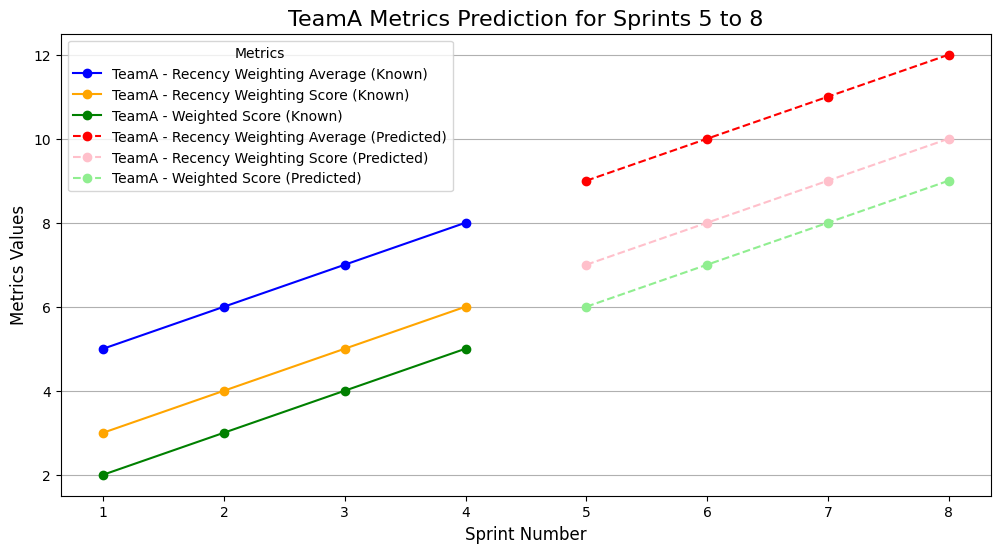

Processing team: TeamB


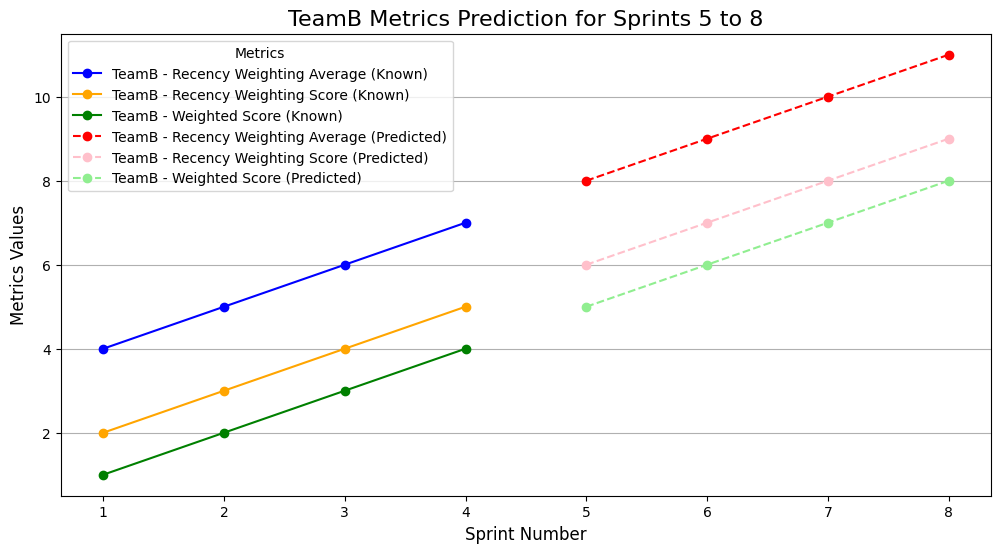

In [9]:
from sklearn.linear_model import LinearRegression

# Sample DataFrame format: (replace with your actual DataFrame)
# Assuming we have a multi-index DataFrame with Team and Sprint as indices
data = {
    'Team': ['TeamA'] * 4 + ['TeamB'] * 4,
    'Sprint': [1, 2, 3, 4] * 2,
    'Recency Weighting Average': [5, 6, 7, 8, 4, 5, 6, 7],
    'Recency Weighting Score': [3, 4, 5, 6, 2, 3, 4, 5],
    'Weighted Score': [2, 3, 4, 5, 1, 2, 3, 4]
}
df = pnd.DataFrame(data).set_index(['Team', 'Sprint'])

# List of metrics
metrics = ['Recency Weighting Average', 'Recency Weighting Score', 'Weighted Score']

# Loop through each team
teams = df.index.get_level_values('Team').unique()

for team in teams:
    print(f"Processing team: {team}")
    
    # Get the data for the specific team
    team_data = df.loc[team]
    
    # Prepare the sprint numbers
    sprints = np.array([1, 2, 3, 4])
    
    # Initialize a dictionary to store predictions
    predictions = {metric: [] for metric in metrics}
    
    # Create a linear regression model for each metric
    for metric in metrics:
        # Extract the known values for the metric
        known_values = team_data[metric].iloc[:4].values.reshape(-1, 1)  # Values for Sprints 1-4
        model = LinearRegression()
        model.fit(sprints.reshape(-1, 1), known_values)  # Fit the model
        
        # Predict for Sprints 5 to 8
        sprint_to_predict = np.array([5, 6, 7, 8]).reshape(-1, 1)
        predicted_values = model.predict(sprint_to_predict)
        
        # Store predictions
        predictions[metric] = predicted_values.flatten()
    
    # Prepare for plotting
    sprint_labels = np.concatenate([sprints, sprint_to_predict.flatten()])
    recency_weighting_avg = np.concatenate([team_data['Recency Weighting Average'].iloc[:4].values, predictions['Recency Weighting Average']])
    recency_weighting_score = np.concatenate([team_data['Recency Weighting Score'].iloc[:4].values, predictions['Recency Weighting Score']])
    weighted_score = np.concatenate([team_data['Weighted Score'].iloc[:4].values, predictions['Weighted Score']])

    # Plotting the results for each team
    plt.figure(figsize=(12, 6))
    
    # Plot known data (Sprints 1-4)
    plt.plot(sprints, team_data['Recency Weighting Average'].iloc[:4], marker='o', label=f'{team} - Recency Weighting Average (Known)', color='blue')
    plt.plot(sprints, team_data['Recency Weighting Score'].iloc[:4], marker='o', label=f'{team} - Recency Weighting Score (Known)', color='orange')
    plt.plot(sprints, team_data['Weighted Score'].iloc[:4], marker='o', label=f'{team} - Weighted Score (Known)', color='green')
    
    # Plot predicted data (Sprints 5-8)
    plt.plot(np.array([5, 6, 7, 8]), predictions['Recency Weighting Average'], marker='o', linestyle='--', label=f'{team} - Recency Weighting Average (Predicted)', color='red')
    plt.plot(np.array([5, 6, 7, 8]), predictions['Recency Weighting Score'], marker='o', linestyle='--', label=f'{team} - Recency Weighting Score (Predicted)', color='pink')
    plt.plot(np.array([5, 6, 7, 8]), predictions['Weighted Score'], marker='o', linestyle='--', label=f'{team} - Weighted Score (Predicted)', color='lightgreen')

    # Adding titles and labels
    plt.title(f'{team} Metrics Prediction for Sprints 5 to 8', fontsize=16)
    plt.xlabel('Sprint Number', fontsize=12)
    plt.ylabel('Metrics Values', fontsize=12)
    plt.xticks(np.arange(1, 9))  # Show all sprint numbers from 1 to 8
    plt.grid(axis='y')
    plt.legend(title="Metrics")
    
    # Show the plot
    plt.show()
